In [1]:
# Package generaux
import spacy
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Packages NLP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

C:\Users\tlp\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Data

In [2]:
df = pd.read_csv(r'data_cleaned/initial_corpus.csv')

print(df.shape)
df.head()

(8918, 8)


,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
1,Le Monde,Récit Les trois semaines qui ont chamboulé l...,2020-03-27,"Éric Albert, Cécile Boutelet, Jérôme Gautheret...","Londres, Berlin, Rome et Bruxelles corresponda...","- Jeudi 26 mars, les Vingt-Sept devaient se r...","pandémie touche tout le monde, indifféremment ...",Monde
2,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro
3,Le Monde (site web),Coronavirus : les trois semaines qui ont chamb...,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet...","Jeudi 26 mars, les Vingt-Sept doivent se réuni...",n visioconférence pour la troisième fois en mo...,"e la tenue de ses comptes publics, n’est pas s...",Monde
4,Le Monde (site web),Marc Lazar : « Plus l’Italie fait nation face ...,2020-03-25,Marc Lazar,Tribune. L’Italie est le pays qui enregistre à...,date du 25 mars le plus grand nombre de morts...,t de la School of Government de la Luiss (Libr...,Monde


### Création d'un dataset sans les références aux nationalités

On extrait des articles tous les mots qui peuvent influencer le modèle dans son apprentissage

In [3]:
# Liste des pays avec leur nationalité, capitale et continent
pays_nationalite = [
    ("Afghanistan", "Afghan", "Kaboul", "Asie"),
    ("Afrique du Sud", "Sud-africain", "Pretoria", "Afrique"),
    ("Albanie", "Albanais", "Tirana", "Europe"),
    ("Algérie", "Algérien", "Alger", "Afrique"),
    ("Allemagne", "Allemand", "Berlin", "Europe"),
    ("Andorre", "Andorran", "Andorre-la-Vieille", "Europe"),
    ("Angola", "Angolais", "Luanda", "Afrique"),
    ("Antigua-et-Barbuda", "Antiguais", "Saint John's", "Amérique du Nord"),
    ("Arabie saoudite", "Saoudien", "Riyad", "Asie"),
    ("Argentine", "Argentin", "Buenos Aires", "Amérique du Sud"),
    ("Arménie", "Arménien", "Erevan", "Europe"),
    ("Australie", "Australien", "Canberra", "Océanie"),
    ("Autriche", "Autrichien", "Vienne", "Europe"),
    ("Azerbaïdjan", "Azéri", "Bakou", "Europe"),
    ("Zimbabwe", "Zimbabwéen", "Harare", "Afrique"),
    ("Égypte", "Égyptien", "Le Caire", "Afrique"),
    ("Émirats arabes unis", "Émirien", "Abou Dabi", "Asie"),
    ("Équateur", "Équatorien", "Quito", "Amérique du Sud"),
    ("Érythrée", "Érythréen", "Asmara", "Afrique"),
    ("Espagne", "Espagnol", "Madrid", "Europe"),
    ("Estonie", "Estonien", "Tallinn", "Europe"),
    ("États-Unis", "Américain", "Washington", "Amérique du Nord"),
    ("Éthiopie", "Éthiopien", "Addis-Abeba", "Afrique"),
    ("Fidji", "Fidjien", "Suva", "Océanie"),
    ("Finlande", "Finlandais", "Helsinki", "Europe"),
    ("France", "Français", "Paris", "Europe"),
    ("Gabon", "Gabonais", "Libreville", "Afrique"),
    ("Gambie", "Gambien", "Banjul", "Afrique"),
    ("Géorgie", "Géorgien", "Tbilissi", "Europe"),
    ("Ghana", "Ghanéen", "Accra", "Afrique"),
    ("Grèce", "Grec", "Athènes", "Europe"),
    ("Grenade", "Grenadien", "Saint-Georges", "Amérique du Nord"),
    ("Guatemala", "Guatémaltèque", "Guatemala", "Amérique du Nord"),
    ("Guinée", "Guinéen", "Conakry", "Afrique"),
    ("Guinée-Bissau", "Bissau-Guinéen", "Bissau", "Afrique"),
    ("Guinée équatoriale", "Équatoguinéen", "Malabo", "Afrique"),
    ("Guyana", "Guyanais", "Georgetown", "Amérique du Sud"),
    ("Haïti", "Haïtien", "Port-au-Prince", "Amérique du Nord"),
    ("Honduras", "Hondurien", "Tegucigalpa", "Amérique du Nord"),
    ("Hongrie", "Hongrois", "Budapest", "Europe"),
    ("Îles Marshall", "Marshallais", "Majuro", "Océanie"),
    ("Inde", "Indien", "New Delhi", "Asie"),
    ("Indonésie", "Indonésien", "Jakarta", "Asie"),
    ("Irak", "Irakien", "Bagdad", "Asie"),
    ("Iran", "Iranien", "Téhéran", "Asie"),
    ("Irlande", "Irlandais", "Dublin", "Europe"),
    ("Islande", "Islandais", "Reykjavik", "Europe"),
    ("Israël", "Israélien", "Jérusalem", "Asie"),
    ("Italie", "Italien", "Rome", "Europe"),
    ("Jamaïque", "Jamaïcain", "Kingston", "Amérique du Nord"),
    ("Japon", "Japonais", "Tokyo", "Asie"),
    ("Jordanie", "Jordanien", "Amman", "Asie"),
    ("Kazakhstan", "Kazakh", "Noursoultan", "Asie"),
    ("Kenya", "Kényan", "Nairobi", "Afrique"),
    ("Kirghizistan", "Kirghize", "Bichkek", "Asie"),
    ("Kiribati", "Kiribatien", "Tarawa", "Océanie"),
    ("Koweït", "Koweïtien", "Koweït", "Asie"),
    ("Laos", "Laotien", "Vientiane", "Asie"),
    ("Lesotho", "Lesothan", "Maseru", "Afrique"),
    ("Lettonie", "Letton", "Riga", "Europe"),
    ("Liban", "Libanais", "Beyrouth", "Asie"),
    ("Libéria", "Libérien", "Monrovia", "Afrique"),
    ("Libye", "Libyen", "Tripoli", "Afrique"),
    ("Liechtenstein", "Liechtensteinois", "Vaduz", "Europe"),
    ("Lituanie", "Lituanien", "Vilnius", "Europe"),
    ("Luxembourg", "Luxembourgeois", "Luxembourg", "Europe"),
    ("Macédoine du Nord", "Macédonien", "Skopje", "Europe"),
    ("Madagascar", "Malgache", "Antananarivo", "Afrique"),
    ("Malaisie", "Malaisien", "Kuala Lumpur", "Asie"),
    ("Malawi", "Malawien", "Lilongwe", "Afrique"),
    ("Maldives", "Maldivien", "Malé", "Asie"),
    ("Mali", "Malien", "Bamako", "Afrique"),
    ("Malte", "Maltais", "La Valette", "Europe"),
    ("Maroc", "Marocain", "Rabat", "Afrique"),
    ("Maurice", "Mauricien", "Port-Louis", "Afrique"),
    ("Mauritanie", "Mauritanien", "Nouakchott", "Afrique"),
    ("Mexique", "Mexicain", "Mexico", "Amérique du Nord"),
    ("Micronésie", "Micronésien", "Palikir", "Océanie"),
    ("Moldavie", "Moldave", "Chisinau", "Europe"),
    ("Monaco", "Monégasque", "Monaco", "Europe"),
    ("Mongolie", "Mongol", "Oulan-Bator", "Asie"),
    ("Monténégro", "Monténégrin", "Podgorica", "Europe"),
    ("Mozambique", "Mozambicain", "Maputo", "Afrique"),
    ("Namibie", "Namibien", "Windhoek", "Afrique"),
    ("Nauru", "Nauruan", "Yaren", "Océanie"),
    ("Népal", "Népalais", "Katmandou", "Asie"),
    ("Nicaragua", "Nicaraguayen", "Managua", "Amérique du Nord"),
    ("Niger", "Nigérien", "Niamey", "Afrique"),
    ("Nigeria", "Nigérian", "Abuja", "Afrique"),
    ("Niue", "Niuéen", "Alofi", "Océanie"),
    ("Norvège", "Norvégien", "Oslo", "Europe"),
    ("Nouvelle-Zélande", "Néo-zélandais", "Wellington", "Océanie"),
    ("Oman", "Omanais", "Mascate", "Asie"),
    ("Ouganda", "Ougandais", "Kampala", "Afrique"),
    ("Ouzbékistan", "Ouzbek", "Tachkent", "Asie"),
    ("Pakistan", "Pakistanais", "Islamabad", "Asie"),
    ("Palaos", "Palauan", "Ngerulmud", "Océanie"),
    ("Panama", "Panaméen", "Panama", "Amérique du Nord"),
    ("Papouasie-Nouvelle-Guinée", "Papouan-Néo-Guinéen", "Port Moresby", "Océanie"),
    ("Paraguay", "Paraguayen", "Asunción", "Amérique du Sud"),
    ("Pays-Bas", "Néerlandais", "Amsterdam", "Europe"),
    ("Pérou", "Péruvien", "Lima", "Amérique du Sud"),
    ("Philippines", "Philippin", "Manille", "Asie"),
    ("Pologne", "Polonais", "Varsovie", "Europe"),
    ("Portugal", "Portugais", "Lisbonne", "Europe"),
    ("Qatar", "Qatarien", "Doha", "Asie"),
    ("République centrafricaine", "Centrafricain", "Bangui", "Afrique"),
    ("République démocratique du Congo", "Congolais", "Kinshasa", "Afrique"),
    ("République dominicaine", "Dominicain", "Saint-Domingue", "Amérique du Nord"),
    ("République tchèque", "Tchèque", "Prague", "Europe"),
    ("Roumanie", "Roumain", "Bucarest", "Europe"),
    ("Royaume-Uni", "Britannique", "Londres", "Europe"),
    ("Russie", "Russe", "Moscou", "Europe"),
    ("Rwanda", "Rwandais", "Kigali", "Afrique"),
    ("Saint-Christophe-et-Niévès", "Saint-Christophien et Névicien", "Basseterre", "Amérique du Nord"),
    ("Saint-Marin", "Saint-Marinais", "Saint-Marin", "Europe"),
    ("Saint-Vincent-et-les-Grenadines", "Saint-Vincentais et Grenadin", "Kingstown", "Amérique du Nord"),
    ("Sainte-Lucie", "Saint-Lucien", "Castries", "Amérique du Nord"),
    ("Salomon", "Salomonais", "Honiara", "Océanie"),
    ("Salvador", "Salvadorien", "San Salvador", "Amérique du Nord"),
    ("Samoa", "Samoan", "Apia", "Océanie"),
    ("São Tomé-et-Príncipe", "Santoméen", "São Tomé", "Afrique"),
    ("Sénégal", "Sénégalais", "Dakar", "Afrique"),
    ("Serbie", "Serbe", "Belgrade", "Europe"),
    ("Seychelles", "Seychellois", "Victoria", "Afrique"),
    ("Sierra Leone", "Sierra-léonais", "Freetown", "Afrique"),
    ("Singapour", "Singapourien", "Singapour", "Asie"),
    ("Slovaquie", "Slovaque", "Bratislava", "Europe"),
    ("Slovénie", "Slovène", "Ljubljana", "Europe"),
    ("Somalie", "Somalien", "Mogadiscio", "Afrique"),
    ("Soudan", "Soudanais", "Khartoum", "Afrique"),
    ("Soudan du Sud", "Sud-Soudanais", "Djouba", "Afrique"),
    ("Sri Lanka", "Sri-lankais", "Sri Jayawardenapura Kotte", "Asie"),
    ("Suède", "Suédois", "Stockholm", "Europe"),
    ("Suisse", "Suisse", "Berne", "Europe"),
    ("Suriname", "Surinamien", "Paramaribo", "Amérique du Sud"),
    ("Syrie", "Syrien", "Damas", "Asie"),
    ("Swaziland", "Swazilandais", "Mbabane", "Afrique"),
    ("Tadjikistan", "Tadjik", "Douchanbé", "Asie"),
    ("Tanzanie", "Tanzanien", "Dodoma", "Afrique"),
    ("Tchad", "Tchadien", "N'Djaména", "Afrique"),
    ("Thaïlande", "Thaïlandais", "Bangkok", "Asie"),
    ("Timor oriental", "Est-timorais", "Dili", "Asie"),
    ("Togo", "Togolais", "Lomé", "Afrique"),
    ("Tonga", "Tongan", "Nuku'alofa", "Océanie"),
    ("Trinité-et-Tobago", "Trinidadien", "Port-d'Espagne", "Amérique du Nord"),
    ("Tunisie", "Tunisien", "Tunis", "Afrique"),
    ("Turkménistan", "Turkmène", "Achgabat", "Asie"),
    ("Turquie", "Turc", "Ankara", "Europe"),
    ("Tuvalu", "Tuvaluan", "Funafuti", "Océanie"),
    ("Ukraine", "Ukrainien", "Kiev", "Europe"),
    ("Uruguay", "Uruguayen", "Montevideo", "Amérique du Sud"),
    ("Vanuatu", "Vanuatuan", "Port-Vila", "Océanie"),
    ("Vatican", "Vaticanais", "Vatican", "Europe"),
    ("Venezuela", "Vénézuélien", "Caracas", "Amérique du Sud"),
    ("Viêt Nam", "Vietnamien", "Hanoï", "Asie"),
    ("Yémen", "Yéménite", "Sanaa", "Asie"),
    ("Zambie", "Zambien", "Lusaka", "Afrique"),
    ("Zimbabwe", "Zimbabwéen", "Harare", "Afrique")
]

df_pays = pd.DataFrame(pays_nationalite, columns=["Pays", "Nationalité", "Capitale", "Continent"])

display(df_pays.head())
df_pays.shape

,Pays,Nationalité,Capitale,Continent
0,Afghanistan,Afghan,Kaboul,Asie
1,Afrique du Sud,Sud-africain,Pretoria,Afrique
2,Albanie,Albanais,Tirana,Europe
3,Algérie,Algérien,Alger,Afrique
4,Allemagne,Allemand,Berlin,Europe


(159, 4)

In [4]:
# Liste des nationalités
nationalites = [
    "Afghan", "Sud-africain", "Albanais", "Algérien", "Allemand", "Andorran", "Angolais", "Antiguais",
    "Saoudien", "Argentin", "Arménien", "Australien", "Autrichien", "Azéri", "Zimbabwéen", "Égyptien",
    "Émirien", "Équatorien", "Érythréen", "Espagnol", "Estonien", "Américain", "Éthiopien", "Fidjien",
    "Finlandais", "Français", "Gabonais", "Gambien", "Géorgien", "Ghanéen", "Grec", "Grenadien",
    "Guatémaltèque", "Guinéen", "Bissau-Guinéen", "Équatoguinéen", "Guyanais", "Haïtien", "Hondurien",
    "Hongrois", "Marshallais", "Indien", "Indonésien", "Irakien", "Iranien", "Irlandais", "Islandais",
    "Israélien", "Italien", "Jamaïcain", "Japonais", "Jordanien", "Kazakh", "Kényan", "Kirghize",
    "Kiribatien", "Koweïtien", "Laotien", "Lesothan", "Letton", "Libanais", "Libérien", "Libyen",
    "Liechtensteinois", "Lituanien", "Luxembourgeois", "Macédonien", "Malgache", "Malaisien", "Malawien",
    "Maldivien", "Malien", "Maltais", "Marocain", "Mauricien", "Mauritanien", "Mexicain", "Micronésien",
    "Moldave", "Monégasque", "Mongol", "Monténégrin", "Mozambicain", "Namibien", "Nauruan", "Népalais",
    "Nicaraguayen", "Nigérien", "Nigérian", "Niuéen", "Norvégien", "Néo-zélandais", "Omanais", "Ougandais",
    "Ouzbek", "Pakistanais", "Palauan", "Panaméen", "Papouan-Néo-Guinéen", "Paraguayen", "Néerlandais",
    "Péruvien", "Philippin", "Polonais", "Portugais", "Qatarien", "Centrafricain", "Congolais", "Dominicain",
    "Tchèque", "Roumain", "Britannique", "Russe", "Rwandais", "Saint-Christophien et Névicien", "Saint-Marinais",
    "Saint-Vincentais et Grenadin", "Saint-Lucien", "Salomonais", "Salvadorien", "Samoan", "Santoméen",
    "Sénégalais", "Serbe", "Seychellois", "Sierra-léonais", "Singapourien", "Slovaque", "Slovène",
    "Somalien", "Soudanais", "Sud-Soudanais", "Sri-lankais", "Suédois", "Suisse", "Surinamien", "Syrien",
    "Swazilandais", "Tadjik", "Tanzanien", "Tchadien", "Thaïlandais", "Est-timorais", "Togolais", "Tongan",
    "Trinidadien", "Tunisien", "Turkmène", "Turc", "Tuvaluan", "Ukrainien", "Uruguayen", "Vanuatuan",
    "Vaticanais", "Vénézuélien", "Vietnamien", "Yéménite", "Zambien", "Zimbabwéen"
]

# Fonction pour générer les différentes formes de nationalités
def generer_formes(nationalite):
    masculin_singulier = nationalite
    masculin_pluriel = nationalite + "s"
    feminin_singulier = nationalite + "e"
    feminin_pluriel = nationalite + "es"
    return masculin_singulier, masculin_pluriel, feminin_singulier, feminin_pluriel

df_nationalites = pd.DataFrame(nationalites, columns=["Nationalité"])
df_nationalites["Masculin Singulier"], df_nationalites["Masculin Pluriel"], df_nationalites["Féminin Singulier"], df_nationalites["Féminin Pluriel"] = zip(*df_nationalites["Nationalité"].apply(generer_formes))

display(df_nationalites.head())
df_nationalites.shape

,Nationalité,Masculin Singulier,Masculin Pluriel,Féminin Singulier,Féminin Pluriel
0,Afghan,Afghan,Afghans,Afghane,Afghanes
1,Sud-africain,Sud-africain,Sud-africains,Sud-africaine,Sud-africaines
2,Albanais,Albanais,Albanaiss,Albanaise,Albanaises
3,Algérien,Algérien,Algériens,Algériene,Algérienes
4,Allemand,Allemand,Allemands,Allemande,Allemandes


(159, 5)

In [ ]:
# Stockage des nationalites
#df_nationalites.to_csv('all_nationalities.csv')

On va maintenant pouvoir extraire toutes les infos relatives aux nationalités :
- en utilisant les dataframes précédents sur les pays et nationalités
- en utilisant spacy qui permet en plus d'identifier des mots plus spécifiques mais révélateurs  
    ex. religion (islam, christianisme, etc.), ethnie (arabes, etc.), etc.

In [5]:
# Import du module de Spacy pour des corpus français
nlp = spacy.load("fr_core_news_sm")

In [6]:
nationalities = pd.concat([df_nationalites[col].apply(lambda x : x.lower()) for col in df_nationalites.columns]).unique()

# Fonction pour extraire les mots et les remplacer arbitrairement par "PAMPLEMOUSSE"
def replace_nationality_entities(text):
    doc = nlp(text)
    replaced_text = []
    replaced_words = []  # Nouvelle liste pour stocker les mots remplacés
    for token in doc:
        if token.ent_type_ == "LOC" or token.ent_type_ == "GPE" or str(token).lower() in nationalities:
            replaced_text.append("PAMPLEMOUSSE")
            replaced_words.append(token.text)  # Ajouter le mot remplacé à la liste
        else:
            replaced_text.append(token.text)
    return " ".join(replaced_text), replaced_words

In [7]:
from tqdm import tqdm

for journal in tqdm(df.CJournal.unique()):
    d = data.loc[data.CJournal == journal].copy()
    d[["texte_processed", "replaced_words"]] = d["Texte"].apply(lambda x: pd.Series(replace_nationality_entities(x)))
    
    display(d.head())
    #d.to_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_'+journal+'.csv',sep=";", index=False)


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]


NameError: name 'data' is not defined

In [24]:
final = pd.concat([
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Figaro.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Monde.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Libération.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Croix.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Parisien.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Echos.csv',sep=";")
])

In [25]:
# Stockage final
#final.to_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE.csv',sep=";", index=False)

# Replace nationality

In [43]:
def replace(x):
    return replace_nationality_entities(x, df_pays.to_dict('records'))

# data["texte_processed"] = data["Texte"].apply(replace)
# data["replaced_words"] = data["Texte"].apply(lambda x: replace(x)[1])
# data

<ipython-input-43-035997c6abfd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["texte_processed"] = data["Texte"].apply(replace)
<ipython-input-43-035997c6abfd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["replaced_words"] = data["Texte"].apply(lambda x: replace(x)[1])


,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,crisis_term,texte_processed,replaced_words
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,migrant_migratoire,(le symbol comptent parfois plus que le fait ....,"[europ, europ, europ, europ, allemagn, europ, ..."
1,Le Monde,Récit Les trois semaines qui ont chamboulé l...,2020-03-27,"Éric Albert, Cécile Boutelet, Jérôme Gautheret...","Londres, Berlin, Rome et Bruxelles corresponda...","- Jeudi 26 mars, les Vingt-Sept devaient se r...","pandémie touche tout le monde, indifféremment ...",Monde,migrant_migratoire,"(PAMPLEMOUSSE , PAMPLEMOUSSE , PAMPLEMOUSSE et...","[europ, europ, europ, europ, europ, europ, eur..."
2,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro,migrant_migratoire,(fin observ de la vi polit français et contrib...,"[alban, europ, europ, europ, alban, europ, all..."
3,Le Monde (site web),Coronavirus : les trois semaines qui ont chamb...,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet...","Jeudi 26 mars, les Vingt-Sept doivent se réuni...",n visioconférence pour la troisième fois en mo...,"e la tenue de ses comptes publics, n’est pas s...",Monde,migrant_migratoire,"(jeud 26 mar , le vingt-sept doivent se réun e...","[europ, europ, europ, europ, europ, europ, eur..."
4,Le Monde (site web),Marc Lazar : « Plus l’Italie fait nation face ...,2020-03-25,Marc Lazar,Tribune. L’Italie est le pays qui enregistre à...,date du 25 mars le plus grand nombre de morts...,t de la School of Government de la Luiss (Libr...,Monde,migrant_migratoire,(tribun . l ’ PAMPLEMOUSSE est le pay qui enre...,"[europ, allemagn, allemand, berlin, franc, fra..."
...,...,...,...,...,...,...,...,...,...,...,...
95,Le Figaro.fr,Paris: une «maison des réfugiés» ouvre ses portes,2019-06-20,Le Figaro avec AFP,"Une «maison des réfugiés», financée par la Mai...",de Paris et centralisant initiatives et infor...,de Paris de se marquer comme une ville refuge...,Figaro,migrant_migratoire,"(une « maison de réfugi » , financ par la mair...","[paris, franc, paris, paris, franc, paris, paris]"
96,Libération (site web),Edition principale «La crise des migrants a ...,2019-06-20,Augustine Passilly,Le Haut-Commissariat de l'ONU pour les réfugié...,lerte sur un record de déplacements forcés. So...,es migrants vénézuéliens à la frontière péruvi...,Libération,migrant_migratoire,(le haut-commissariat de l'onu pour le réfugi ...,"[afghanistan, afriqu, afriqu, allemagn, keni, ..."
97,Le Monde.fr,Bac 2019 histoire-géo : le corrigé de la série S,2019-06-18,nan,"Après la philosophie, lundi 17 juin, les candi...",s au bac 2019 ont planché sur les épreuves d'h...,aciques et ponctuels; dans la troisième des fi...,Monde,migrant_migratoire,"(apres la philosoph , lund 17 juin , le candid...","[europ, europ, europ, europ, europ, allemagn, ..."
98,Le Figaro.fr,"Qu’est-ce que le MED 7, l’alliance des pays du...",2019-06-14,"Baldi, Gabriel","Le Med 7, qu’est-ce que c’est? Composé de sept...","ys du sud de l’Union européenne (France, Espag...",ccupation turque du nord de l’île ou encore la...,Figaro,migrant_migratoire,"(le med 7 , qu ’ est-ce que c ’ est ? compos d...","[europ, europ, europ, europ, europ, europ, eur..."


# NLP humanitaire vs securitaire

In [8]:
# Données annotées
gs_intial = pd.read_csv('./data_cleaned/gold_standard_annote.csv').drop(["is_humanitaire_check","is_securitaire_check","disagreement"], axis=1)
gs_complement = pd.read_csv('./data_cleaned/gold_standard_annote_complement.csv')

gs = pd.concat([gs_intial, gs_complement])
gs

,Journal,Titre,Date,Auteur,Texte,is_humanitaire,is_securitaire,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words,annee
0,"La Croix, no. 40303",VU D'ITALIE Matteo Renzi veut un budget « en e...,2015-10-01,DANCER Marie,La saison budgétaire bat son plein en Europe. ...,0,0,me la France et les autres pays de la zone eur...,"ns le même temps, l'Italie réclame, comme l'Au...",Croix,La saison budgétaire bat son plein en PAMPLEMO...,"['Europe', 'la', 'France', ""l'"", 'Italie', 'Br...",2015
1,"La Croix, no. 40331","Ankara, partenaire incontournable des Européen...",2015-11-03,LE TALLEC Camille,BRUXELLES De notre correspondante Avec rés...,0,0,"e et sobriété, l'Union européenne a réagi aux ...","moment » , estimait de son côté le chef de l'...",Croix,BRUXELLES De notre correspondante Avec r...,"['Turquie', 'Bruxelles', 'Ankara', 'Turquie', ...",2015
2,"La Croix, no. 40327","Jeunes, réfugiés et vulnérables L'Autriche ve...",2015-10-29,VERDIER Marie,La longue route des migrants fluctue au gré de...,1,1,ermetures de frontière. À mesure que la Hongri...,semigratoire est susceptible de « provoquer u...,Croix,La longue route des migrants fluctue au gré de...,"['Hongrie', 'Serbie', 'Croatie', 'Grèce', 'Oue...",2015
3,"La Croix, no. 40341",Éditorial Ensemble,2015-11-16,GOUBERT Guillaume,"Depuis vendredi, la menace terroriste en Franc...",0,1,complètement changé de dimension. Ce que les s...,symbole serait que la France bénéficie de renf...,Croix,"Depuis vendredi , la menace terroriste en PAMP...","['France', 'La', 'France', 'Sahel', 'Proche', ...",2015
4,"La Croix, no. 40529",Entretien « Réduire la distance entre les élit...,2016-06-28,PLOQUIN Jean-Christophe,Qu'est-ce qui explique le malaise d'une partie...,0,1,s Européens vis-à-vis de la construction europ...,ui resterait ouverte à d'autres qui voudraient...,Croix,Qu' est -ce qui explique le malaise d' une par...,"['Européens', 'Portugal', 'Espagne', 'Italie',...",2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Le Parisien,Un thème incontournable de la campagne préside...,2016-11-03,NaN,Par Philippe Martinat C'est un signe qui ne ...,0,1,mpe pas : « Le président suit personnellement ...,"érieur, François Hollande tente de maintenir l...",Parisien,Par Philippe Martinat C' est un signe qui n...,"['Calais', ""L'"", 'Elysée', 'Etat', 'Calais', '...",2016
95,Le Parisien (site web),Emploi : Macron en Europe de l'Est pour encadr...,2017-08-23,"Aurélie Rossignol, avec AFP","Timing parfait. Alors qu'en France, le gouvern...",0,0,nt présente une première version de la réforme...,"t débouché, à fin mars 2017, sur 33 suspension...",Parisien,PAMPLEMOUSSE parfait . Alors qu' en PAMPLEMOUS...,"['Timing', 'France', 'Français', 'Roumanie', '...",2017
96,Le Parisien (site web),L'Europe tangue sur la question des migrants,2018-06-28,Ava Djamshidi (avec CdS),C'est le paradoxe de cette grand-messe entre l...,0,1,28 chefs d'Etat et de gouvernements présents :...,xer la question migratoire au centre des discu...,Parisien,C' est le paradoxe de cette grand-messe entre ...,"['Etat', 'Autriche', 'Italie', 'Vieux', 'Conti...",2018
97,Le Parisien,Par Marie-Anne Gairaud Et aussi D'incidents en,2019-12-18,Marie-Anne Gairaud,Par Marie-Anne Gairaud Et aussi D'incident...,1,1,n incidence ? C'est peu dire que la mandatur...,inimise aujourd'hui cette crise : « Ils étaien...,Parisien,Par Marie-Anne Gairaud Et aussi D' incid...,"['Paris', 'Paris', 'la', 'Ville', 'La', 'Ville...",2019


### Entrainement

Nous avons testé différents modèles (Random, Forest, Logistic Regression, Naive Bayes) et plusieurs paramètres pour chacun. Les meilleurs résultats sont obtenus pour chaque catégorie par l'estimateur baysien avec une précision de 0.78 pour les articles humanitaires et 0.73 pour les articles sécuritaires.

In [9]:
# Division des données en train et tes set
X_train, X_test, y_train, y_test = train_test_split(gs['Texte'], gs[['is_humanitaire', 'is_securitaire']], test_size=0.2, random_state=42)

clf_humanitaire = MultinomialNB(alpha=.8)
clf_securitaire = MultinomialNB(alpha=.2)

for category, classifieur in [
    ["is_humanitaire",clf_humanitaire],
    ["is_securitaire",clf_securitaire]
] :
    # Création d'un vecteur de comptage pour transformer les textes en matrices de fréquence de mots
    vectorizer = CountVectorizer()

    # Transformation des textes d'entraînement et de test
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)

    # Entrainement et test de performance
    classifieur.fit(X_train_vect, y_train[category])
    y_pred_humanitaire =classifieur.predict(X_test_vect)
    
    print(f"\n Résultats détaillés pour {category}")
    print(classification_report(y_test[category], y_pred_humanitaire))


 Résultats détaillés pour is_humanitaire
              precision    recall  f1-score   support

           0       0.91      0.75      0.82        53
           1       0.63      0.85      0.72        26

    accuracy                           0.78        79
   macro avg       0.77      0.80      0.77        79
weighted avg       0.82      0.78      0.79        79


 Résultats détaillés pour is_securitaire
              precision    recall  f1-score   support

           0       0.73      0.63      0.68        35
           1       0.73      0.82      0.77        44

    accuracy                           0.73        79
   macro avg       0.73      0.72      0.73        79
weighted avg       0.73      0.73      0.73        79



# Application

In [14]:
df_cleaned = pd.read_csv('./data_cleaned/corpus_cleaned_PAMPLEMOUSSE.csv',sep=";")
df_cleaned["Année"] = df.Date.apply(lambda x: x[:4])
df_cleaned.head()

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words,Année
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,"['Rome', 'Bergame', 'russe', 'italien', 'De', ...",2020
1,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro,Fin observateur de la vie politique PAMPLEMOUS...,"['française', 'États', 'l’', 'Macédoine', 'du'...",2020
2,Le Figaro (site web),"Coronavirus, un révélateur des faiblesses de l...",2020-03-12,"Long, Didier, Laye, Sébastien",Didier Long est physicien. Sébastien Laye est ...,"repreneur dans l’immobilier, chercheur associé...",faire un choix clair: l’idéologie rigoriste as...,Figaro,Didier Long est physicien . Sébastien Laye est...,"['l’', 'Chine', 'l’', 'région', 'de', 'Wuhan',...",2020
3,"Le Figaro, no. 23505",EN BREF,2020-03-12,"Portes, Thierry",Collision entre un navire grec et un patrouill...,turc Les garde-côtes grecs ont déclaré qu'un ...,"en Afghanistan, ouvrant la voie à des pourparl...",Figaro,Collision entre un navire PAMPLEMOUSSE et un p...,"['grec', 'turc', 'grecs', 'turc', 'turc', ""l'""...",2020
4,Le Figaro (site web),Coralie Delaume: «Un choc externe pourrait pro...,2020-03-11,"Imad, Joachim",Coralie Delaume est essayiste. Elle a notammen...,crit Le Couple franco-allemand n’existe pas (M...,on approche du la fin. De celle de l’Union eur...,Figaro,Coralie Delaume est essayiste . Elle a notamme...,"['FIGAROVOX.-', 'italien', 'l’', 'Quelles', 'l...",2020


In [15]:
# Application
print("Prediction is_humanitaire")
df_cleaned["is_humanitaire_pred"] = clf_humanitaire.predict(vectorizer.transform(df_cleaned["texte_processed"]))
print("Prediction is_securitaire")
df_cleaned["is_securitaire_pred"] = clf_securitaire.predict(vectorizer.transform(df_cleaned["texte_processed"]))
print("Done")

Prediction is_humanitaire
Prediction is_securitaire
Done


In [16]:
# Stat desc
display(df_cleaned[["CJournal","is_humanitaire_pred","is_securitaire_pred"]].groupby(["is_humanitaire_pred","is_securitaire_pred"]).count())
       
display(df_cleaned[["CJournal","Texte","is_humanitaire_pred","is_securitaire_pred"]].groupby(["CJournal","is_humanitaire_pred","is_securitaire_pred"]).count())

CJournal
is_humanitaire_pred is_securitaire_pred          
0                   0                        2356
                    1                        2778
1                   0                         977
                    1                        2807

Texte
CJournal   is_humanitaire_pred is_securitaire_pred       
Croix      0                   0                      153
                               1                      192
           1                   0                      155
                               1                      297
Echos      0                   0                      388
                               1                      457
           1                   0                       81
                               1                      338
Figaro     0                   0                      804
                               1                     1009
           1                   0                      270
                               1                      947
Libération 0                   0                      240
                               1                      220
           1                   0                      119
                               1                      327
Monde      0                   0                      629
                               1                      761
           1                   0                      209
                               1                      633
Parisien   0                   0                      142
                               1                      139
           1                   0                      143
                               1                      265

Proportion d'articles classés comme humanitaires et sécuritaires :
Humanitaires : 42.43%
Sécuritaires : 62.63%

Analyse par journaux :
            is_humanitaire_pred  is_securitaire_pred
CJournal                                            
Croix                  0.567127             0.613551
Echos                  0.328800             0.629600
Figaro                 0.401650             0.645545
Libération             0.492117             0.600225
Monde                  0.377240             0.624552
Parisien               0.592163             0.586357

Analyse par années :
       is_humanitaire_pred  is_securitaire_pred
Année                                          
2015              0.480489             0.699577
2016              0.356365             0.646985
2017              0.348407             0.533402
2018              0.378397             0.617527
2019              0.392327             0.534653
2020              0.573394             0.607798
2021              0.615226         

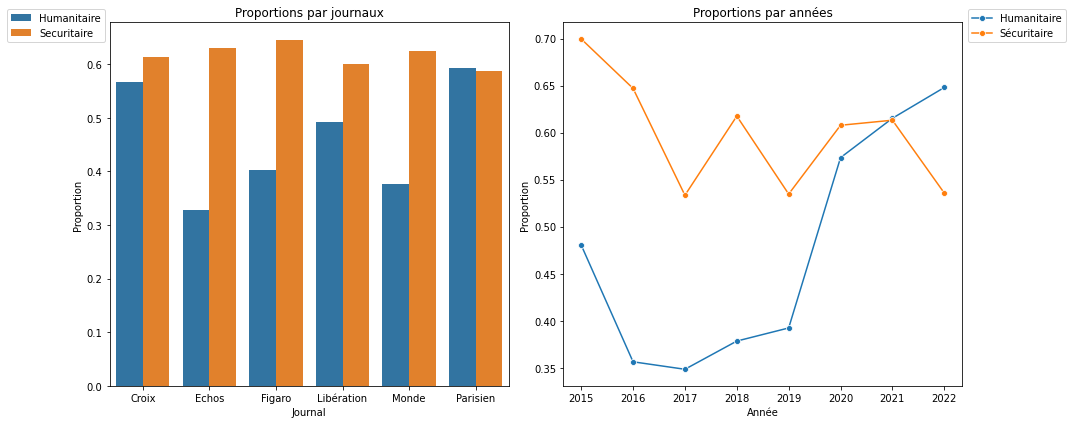

In [17]:
# Analyser la proportion d'articles de chaque type
print("Proportion d'articles classés comme humanitaires et sécuritaires :")
prop_humanitaire = df_cleaned['is_humanitaire_pred'].mean()
prop_securitaire = df_cleaned['is_securitaire_pred'].mean()
print(f"Humanitaires : {prop_humanitaire * 100:.2f}%")
print(f"Sécuritaires : {prop_securitaire * 100:.2f}%")

# Segmentation par journaux
print("\nAnalyse par journaux :")
grouped_by_journal = df_cleaned.loc[df_cleaned["Année"]>"2014"].groupby('CJournal')
journal_analysis = grouped_by_journal.agg({
    'is_humanitaire_pred': 'mean',
    'is_securitaire_pred': 'mean'
})
print(journal_analysis)

# Segmentation par années
print("\nAnalyse par années :")
df_cleaned["Année"] = df_cleaned["Date"].apply(lambda x: x[:4])
grouped_by_year = df_cleaned.loc[df_cleaned["Année"]>"2014"].groupby('Année')
year_analysis = grouped_by_year.agg({
    'is_humanitaire_pred': 'mean',
    'is_securitaire_pred': 'mean'
})
print(year_analysis)

# Visualisation des proportions d'articles classés humanitaires et sécuritaires
plt.figure(figsize=(15, 6))

# Graphique à barres pour les journaux
plt.subplot(1, 2, 1)
data_formated = pd.melt(journal_analysis.reset_index().rename(columns={"is_humanitaire_pred":"Humanitaire","is_securitaire_pred":"Securitaire"}), id_vars=['CJournal'], var_name='categories', value_name='proportion').rename(columns={"is_humanitaire_pred":"Humanitaire","is_securitaire_pred":"Securitaire"})
sns.barplot(data_formated, x="CJournal", y="proportion", hue="categories")
plt.title("Proportions par journaux")
plt.xlabel("Journal")
plt.ylabel("Proportion")
plt.legend(bbox_to_anchor=(0.001, 1.05), loc='upper right')

# Graphique à lignes pour les années
plt.subplot(1, 2, 2)
sns.lineplot(x=year_analysis.index, y='is_humanitaire_pred', data=year_analysis, label='Humanitaire', marker='o')
sns.lineplot(x=year_analysis.index, y='is_securitaire_pred', data=year_analysis, label='Sécuritaire', marker='o')
plt.title("Proportions par années")
plt.xlabel("Année")
plt.ylabel("Proportion")
plt.legend(bbox_to_anchor=(1.001, 1.05), loc='upper left')


# Afficher les graphiques
plt.tight_layout()
plt.show()


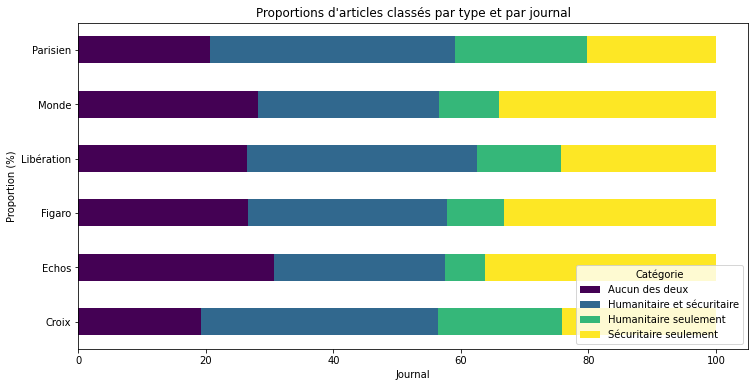

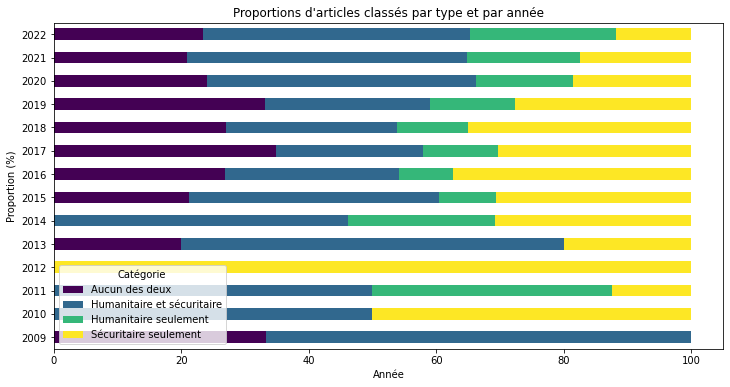

In [71]:
# Calcul des catégories
df_cleaned['category'] = (
    df_cleaned['is_humanitaire_pred'].astype(str) + '_' + df_cleaned['is_securitaire_pred'].astype(str)
)
# Convertir les catégories en descriptifs
df_cleaned['category'] = df_cleaned['category'].replace({
    '1_0': 'Humanitaire seulement',
    '0_1': 'Sécuritaire seulement',
    '1_1': 'Humanitaire et sécuritaire',
    '0_0': 'Aucun des deux'
})

# Segmentation par journaux
grouped_by_journal = df_cleaned.groupby(['CJournal', 'category']).size().unstack().fillna(0)

# Calcul des proportions pour chaque journal
proportions_by_journal = grouped_by_journal.div(grouped_by_journal.sum(axis=1), axis=0) * 100

# Créer un graphique à barres empilées à 100% pour les journaux
proportions_by_journal.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title("Proportions d'articles classés par type et par journal")
plt.xlabel("Journal")
plt.ylabel("Proportion (%)")
plt.legend(title="Catégorie")
plt.show()

# Segmentation par années
grouped_by_year = df_cleaned.groupby(['Année', 'category']).size().unstack().fillna(0)

# Calcul des proportions pour chaque année
proportions_by_year = grouped_by_year.div(grouped_by_year.sum(axis=1), axis=0) * 100

# Créer un graphique à barres empilées à 100% pour les années
proportions_by_year.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title("Proportions d'articles classés par type et par année")
plt.xlabel("Année")
plt.ylabel("Proportion (%)")
plt.legend(title="Catégorie")
plt.show()


In [104]:
df_nationalites.apply()

,Nationalité,Masculin Singulier,Masculin Pluriel,Féminin Singulier,Féminin Pluriel
0,Afghan,Afghan,Afghans,Afghane,Afghanes
1,Sud-africain,Sud-africain,Sud-africains,Sud-africaine,Sud-africaines
2,Albanais,Albanais,Albanaiss,Albanaise,Albanaises
3,Algérien,Algérien,Algériens,Algériene,Algérienes
4,Allemand,Allemand,Allemands,Allemande,Allemandes
...,...,...,...,...,...
154,Vénézuélien,Vénézuélien,Vénézuéliens,Vénézuéliene,Vénézuélienes
155,Vietnamien,Vietnamien,Vietnamiens,Vietnamiene,Vietnamienes
156,Yéménite,Yéménite,Yéménites,Yéménitee,Yéménitees
157,Zambien,Zambien,Zambiens,Zambiene,Zambienes


In [113]:
df_nationalites = df_nationalites.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df_pays = df_pays.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [115]:
from tqdm import tqdm
# On teste toutes les nationalités possibles et leurs extansions
df_cleaned['replaced_words'] = df_cleaned.replaced_words.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
word_to_eliminate = ["l'","la","de","-","l'","l'","l’","la","le"]
L = []
for replaced_words in tqdm(df_cleaned.replaced_words) :
    l = []
    for word in replaced_words :
        word = word.lower()
        if word in df_nationalites["Masculin Singulier"].unique() :
            word = df_nationalites.loc[df_nationalites["Masculin Singulier"]==word,"Nationalité"].iloc[0]
        elif word in df_nationalites["Masculin Pluriel"].unique() :
            word = df_nationalites.loc[df_nationalites["Masculin Pluriel"]==word,"Nationalité"].iloc[0]
        elif word in df_nationalites["Féminin Singulier"].unique() :
            word = df_nationalites.loc[df_nationalites["Féminin Singulier"]==word,"Nationalité"].iloc[0]
        elif word in df_nationalites["Féminin Pluriel"].unique() :
            word = df_nationalites.loc[df_nationalites["Féminin Pluriel"]==word,"Nationalité"].iloc[0]
        else :
            if word in df_pays["Capitale"].unique() :
                word = df_pays.loc[df_pays["Capitale"]==word,"Nationalité"].iloc[0]
            if word in df_pays["Pays"].unique() :
                word = df_pays.loc[df_pays["Pays"]==word,"Nationalité"].iloc[0]

        l.append(word)
    
    L.append(l)       

100%|██████████████████████████████████████████████████████████████████████████████| 8918/8918 [03:34<00:00, 41.57it/s]


In [116]:
df_cleaned["replaced_words_cleaned"] = pd.Series(L)
df_cleaned

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words,is_humanitaire_pred,is_securitaire_pred,Année,category,replaced_words_cleaned
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,"[Rome, Bergame, russe, italien, De, Russie, Ch...",0,1,2020,Sécuritaire seulement,"[italien, bergame, russe, italien, de, russe, ..."
1,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro,Fin observateur de la vie politique PAMPLEMOUS...,"[française, États, l’, Macédoine, du, Nord, Ba...",0,0,2020,Aucun des deux,"[français, états, l’, macédoine, du, nord, bal..."
2,Le Figaro (site web),"Coronavirus, un révélateur des faiblesses de l...",2020-03-12,"Long, Didier, Laye, Sébastien",Didier Long est physicien. Sébastien Laye est ...,"repreneur dans l’immobilier, chercheur associé...",faire un choix clair: l’idéologie rigoriste as...,Figaro,Didier Long est physicien . Sébastien Laye est...,"[l’, Chine, l’, région, de, Wuhan, l’, l’, Eur...",0,0,2020,Aucun des deux,"[l’, chine, l’, région, de, wuhan, l’, l’, eur..."
3,"Le Figaro, no. 23505",EN BREF,2020-03-12,"Portes, Thierry",Collision entre un navire grec et un patrouill...,turc Les garde-côtes grecs ont déclaré qu'un ...,"en Afghanistan, ouvrant la voie à des pourparl...",Figaro,Collision entre un navire PAMPLEMOUSSE et un p...,"[grec, turc, grecs, turc, turc, l', Europe, ru...",0,0,2020,Aucun des deux,"[grec, turc, grec, turc, turc, l', europe, rus..."
4,Le Figaro (site web),Coralie Delaume: «Un choc externe pourrait pro...,2020-03-11,"Imad, Joachim",Coralie Delaume est essayiste. Elle a notammen...,crit Le Couple franco-allemand n’existe pas (M...,on approche du la fin. De celle de l’Union eur...,Figaro,Coralie Delaume est essayiste . Elle a notamme...,"[FIGAROVOX.-, italien, l’, Quelles, l’, l’, l’...",0,0,2020,Aucun des deux,"[figarovox.-, italien, l’, quelles, l’, l’, l’..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8913,Les Echos,Joe Biden met en scène sa présidence appliquée...,2021-07-22,NaN,scandinavie - : La Suède a présenté jeudi un ...,jet de loi pérennisant le durcissement de ses ...,seront convertibles en droits de résidence pe...,Echos,scandinavie - : La PAMPLEMOUSSE a présenté j...,"[Suède, suédois]",1,1,2021,Humanitaire et sécuritaire,"[suédois, suédois]"
8914,Les Echos,"Aux Canaries, le drame de l'immigration a déso...",2021-05-29,NaN,De tous les dossiers posés sur la table des né...,"iations entre Bruxelles et Ankara, c'est peut-...",Européens partagent véritablement une volonté...,Echos,De tous les dossiers posés sur la table des né...,"[Bruxelles, Ankara, Bruxelles, Européens, syri...",1,1,2021,Humanitaire et sécuritaire,"[bruxelles, turc, bruxelles, européens, syrien..."
8915,Les Echos,Un nouvel élan pour l'intégration européenne ?,2020-08-30,NaN,Cela aurait pu être l'étincelle dans le baril ...,"poudre. Pour les Européens, le Brexit avait to...","en, malgré son manque de maniabilité,reste l'e...",Echos,Cela aurait pu être l' étincelle dans le baril...,"[Européens, Brexit, Londres, Europe, Européens...",0,1,2020,Sécuritaire seulement,"[européens, brexit, britannique, europe, europ..."
8916,Les Echos,"2020, l'année furieuse",2020-08-14,NaN,C'est un plongeon généralisé. Tous les indicat...,s de flux d'entrée et de séjour sur le territo...,mie a également influé sur les sorties du terr...,Echos,C' est un plongeon généralisé . Tous les indic...,"[France, France, La, Chine, La, France, la, Fr...",1,0,2020,Humanitaire seulement,"[français, français, la, chine, la, franç

In [117]:
df_cleaned[["Journal","Titre","Date","Auteur","Texte","extrait_debut","extrait_fin","CJournal","texte_processed","replaced_words","Année","replaced_words_cleaned"]].to_csv('./data_cleaned/df_cleaned_v2.csv')

In [118]:
df_cleaned

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words,is_humanitaire_pred,is_securitaire_pred,Année,category,replaced_words_cleaned
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,"[Rome, Bergame, russe, italien, De, Russie, Ch...",0,1,2020,Sécuritaire seulement,"[italien, bergame, russe, italien, de, russe, ..."
1,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro,Fin observateur de la vie politique PAMPLEMOUS...,"[française, États, l’, Macédoine, du, Nord, Ba...",0,0,2020,Aucun des deux,"[français, états, l’, macédoine, du, nord, bal..."
2,Le Figaro (site web),"Coronavirus, un révélateur des faiblesses de l...",2020-03-12,"Long, Didier, Laye, Sébastien",Didier Long est physicien. Sébastien Laye est ...,"repreneur dans l’immobilier, chercheur associé...",faire un choix clair: l’idéologie rigoriste as...,Figaro,Didier Long est physicien . Sébastien Laye est...,"[l’, Chine, l’, région, de, Wuhan, l’, l’, Eur...",0,0,2020,Aucun des deux,"[l’, chine, l’, région, de, wuhan, l’, l’, eur..."
3,"Le Figaro, no. 23505",EN BREF,2020-03-12,"Portes, Thierry",Collision entre un navire grec et un patrouill...,turc Les garde-côtes grecs ont déclaré qu'un ...,"en Afghanistan, ouvrant la voie à des pourparl...",Figaro,Collision entre un navire PAMPLEMOUSSE et un p...,"[grec, turc, grecs, turc, turc, l', Europe, ru...",0,0,2020,Aucun des deux,"[grec, turc, grec, turc, turc, l', europe, rus..."
4,Le Figaro (site web),Coralie Delaume: «Un choc externe pourrait pro...,2020-03-11,"Imad, Joachim",Coralie Delaume est essayiste. Elle a notammen...,crit Le Couple franco-allemand n’existe pas (M...,on approche du la fin. De celle de l’Union eur...,Figaro,Coralie Delaume est essayiste . Elle a notamme...,"[FIGAROVOX.-, italien, l’, Quelles, l’, l’, l’...",0,0,2020,Aucun des deux,"[figarovox.-, italien, l’, quelles, l’, l’, l’..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8913,Les Echos,Joe Biden met en scène sa présidence appliquée...,2021-07-22,NaN,scandinavie - : La Suède a présenté jeudi un ...,jet de loi pérennisant le durcissement de ses ...,seront convertibles en droits de résidence pe...,Echos,scandinavie - : La PAMPLEMOUSSE a présenté j...,"[Suède, suédois]",1,1,2021,Humanitaire et sécuritaire,"[suédois, suédois]"
8914,Les Echos,"Aux Canaries, le drame de l'immigration a déso...",2021-05-29,NaN,De tous les dossiers posés sur la table des né...,"iations entre Bruxelles et Ankara, c'est peut-...",Européens partagent véritablement une volonté...,Echos,De tous les dossiers posés sur la table des né...,"[Bruxelles, Ankara, Bruxelles, Européens, syri...",1,1,2021,Humanitaire et sécuritaire,"[bruxelles, turc, bruxelles, européens, syrien..."
8915,Les Echos,Un nouvel élan pour l'intégration européenne ?,2020-08-30,NaN,Cela aurait pu être l'étincelle dans le baril ...,"poudre. Pour les Européens, le Brexit avait to...","en, malgré son manque de maniabilité,reste l'e...",Echos,Cela aurait pu être l' étincelle dans le baril...,"[Européens, Brexit, Londres, Europe, Européens...",0,1,2020,Sécuritaire seulement,"[européens, brexit, britannique, europe, europ..."
8916,Les Echos,"2020, l'année furieuse",2020-08-14,NaN,C'est un plongeon généralisé. Tous les indicat...,s de flux d'entrée et de séjour sur le territo...,mie a également influé sur les sorties du terr...,Echos,C' est un plongeon généralisé . Tous les indic...,"[France, France, La, Chine, La, France, la, Fr...",1,0,2020,Humanitaire seulement,"[français, français, la, chine, la, franç

In [119]:
stat_figaro = pd.DataFrame()
stat_monde = pd.DataFrame()
stat_liberation = pd.DataFrame()
stat_croix = pd.DataFrame()
stat_parisien = pd.DataFrame()
stat_echos = pd.DataFrame()

stat = pd.DataFrame()

for journal, dataframe in [
    ["Figaro", stat_figaro],
    ["Monde", stat_monde],
    ["Libération", stat_liberation],
    ["Croix", stat_croix],
    ["Parisien", stat_parisien],
    ["Echos", stat_echos],
] :
    print(f"Traitement de {journal}")
    df = df_cleaned.loc[df_cleaned.CJournal==journal]
    
    for year in df["Année"].unique():
        print(year)
        data = df.loc[df["Année"]==year]
    
        dict_humanitaire = {}
        dict_securitaire = {}

        for replaced_words in np.array(data.loc[data["is_humanitaire_pred"]==1, "replaced_words_cleaned"]) :
            for word in replaced_words :
                word = word.lower()

                if word not in dict_humanitaire.keys():
                    dict_humanitaire[word] = 1
                else :
                    dict_humanitaire[word] += 1

        for replaced_words in np.array(data.loc[data["is_securitaire_pred"]==1, "replaced_words_cleaned"]) :
            for word in replaced_words :
                word = word.lower()
                        
                if word not in dict_securitaire.keys():
                    dict_securitaire[word] = 1
                else :
                    dict_securitaire[word] += 1

        # Convertir les dictionnaires en dataframes
        df_huma = pd.DataFrame(list(dict_humanitaire.items()), columns=['mots', 'occurence_huma'])
        df_secu = pd.DataFrame(list(dict_securitaire.items()), columns=['mots', 'occurence_secu'])

        # Fusionner les deux dataframes sur la colonne 'Mot'
        result_df = pd.merge(df_huma, df_secu, on='mots', how='outer')

        ### Nombre d'articles
        print("Process nombre d'article")
        dict_humanitaire = {}
        dict_securitaire = {}

        for word in result_df.mots :            
            for replaced_words in data.loc[data["is_humanitaire_pred"]==1, "replaced_words_cleaned"] :
                word = word.lower()
                if word in replaced_words :  
                    if word not in dict_humanitaire.keys():
                        dict_humanitaire[word] = 1
                    else :
                        dict_humanitaire[word] += 1

            for replaced_words in data.loc[data["is_securitaire_pred"]==1, "replaced_words_cleaned"] :
                word = word.lower()
                if word in replaced_words : 
                    if word not in dict_securitaire.keys():
                        dict_securitaire[word] = 1
                    else :
                        dict_securitaire[word] += 1
        
        # Convertir les dictionnaires en dataframes
        df_huma = pd.DataFrame(list(dict_humanitaire.items()), columns=['mots', 'articles_huma'])
        df_secu = pd.DataFrame(list(dict_securitaire.items()), columns=['mots', 'articles_secu'])

        # Fusionner les deux dataframes sur la colonne 'Mot'
        result_df = pd.merge(result_df, df_huma, on='mots', how='left')
        result_df = pd.merge(result_df, df_secu, on='mots', how='left')

        # Remplacer les valeurs manquantes par 0
        result_df = result_df.fillna(0)
        result_df.insert(0,"journal",journal)
        result_df.insert(1,"annees",year)
        
        stat = pd.concat([
            stat,
            result_df
        ])
    
            

Traitement de Figaro
2020
Process nombre d'article
2019
Process nombre d'article
2018
Process nombre d'article
2017
Process nombre d'article
2016
Process nombre d'article
2015
Process nombre d'article
2014
Process nombre d'article
2013
Process nombre d'article
2011
Process nombre d'article
2022
Process nombre d'article
2021
Process nombre d'article
Traitement de Monde
2020
Process nombre d'article
2019
Process nombre d'article
2018
Process nombre d'article
2017
Process nombre d'article
2016
Process nombre d'article
2015
Process nombre d'article
2014
Process nombre d'article
2012
Process nombre d'article
2010
Process nombre d'article
2009
Process nombre d'article
2022
Process nombre d'article
2021
Process nombre d'article
Traitement de Libération
2020
Process nombre d'article
2019
Process nombre d'article
2018
Process nombre d'article
2017
Process nombre d'article
2016
Process nombre d'article
2015
Process nombre d'article
2014
Process nombre d'article
2013
Process nombre d'article
2011

In [120]:
stat.to_csv('./data_cleaned/stat_nat_huma_secu.csv')

In [121]:
stat
for journal in stat.journal.unique():
    print(journal, "Humanitaire")
    display(stat.loc[stat.journal == journal].sort_values(by=["occurence_huma"], ascending=False).head(5))
    
    print(journal, "Securitaire")
    display(stat.loc[stat.journal == journal].sort_values(by=["occurence_secu"], ascending=False).head(5))

Figaro Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
10,Figaro,2015,allemand,636.0,1169.0,182.0,284.0
147,Figaro,2016,turc,575.0,1257.0,103.0,224.0
18,Figaro,2015,europe,543.0,950.0,220.0,320.0
0,Figaro,2016,français,508.0,1215.0,141.0,293.0
11,Figaro,2015,français,503.0,1009.0,155.0,267.0


Figaro Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
70,Figaro,2016,allemand,328.0,1368.0,102.0,307.0
147,Figaro,2016,turc,575.0,1257.0,103.0,224.0
0,Figaro,2016,français,508.0,1215.0,141.0,293.0
17,Figaro,2016,europe,371.0,1195.0,160.0,347.0
10,Figaro,2015,allemand,636.0,1169.0,182.0,284.0


Monde Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
4,Monde,2016,français,582.0,1093.0,151.0,294.0
34,Monde,2015,français,568.0,1122.0,142.0,256.0
202,Monde,2016,grec,553.0,755.0,113.0,187.0
54,Monde,2016,turc,512.0,928.0,124.0,178.0
21,Monde,2015,allemand,507.0,1051.0,142.0,243.0


Monde Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
1,Monde,2016,europe,505.0,1307.0,157.0,317.0
34,Monde,2015,français,568.0,1122.0,142.0,256.0
4,Monde,2016,français,582.0,1093.0,151.0,294.0
16,Monde,2016,allemand,351.0,1091.0,123.0,268.0
21,Monde,2015,allemand,507.0,1051.0,142.0,243.0


Libération Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
47,Libération,2018,français,293.0,347.0,59.0,84.0
33,Libération,2016,grec,259.0,295.0,26.0,39.0
12,Libération,2015,français,247.0,339.0,53.0,74.0
38,Libération,2018,italien,217.0,377.0,43.0,75.0
4,Libération,2015,syrien,180.0,219.0,47.0,63.0


Libération Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
38,Libération,2018,italien,217.0,377.0,43.0,75.0
47,Libération,2018,français,293.0,347.0,59.0,84.0
12,Libération,2015,français,247.0,339.0,53.0,74.0
33,Libération,2016,grec,259.0,295.0,26.0,39.0
46,Libération,2018,allemand,98.0,294.0,31.0,68.0


Croix Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
17,Croix,2018,français,342.0,324.0,62.0,63.0
0,Croix,2020,turc,190.0,187.0,26.0,24.0
25,Croix,2018,italien,189.0,227.0,46.0,53.0
4,Croix,2020,grec,173.0,168.0,28.0,25.0
40,Croix,2018,vénézuélien,147.0,109.0,11.0,7.0


Croix Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
17,Croix,2018,français,342.0,324.0,62.0,63.0
83,Croix,2016,turc,67.0,266.0,15.0,36.0
79,Croix,2018,allemand,134.0,248.0,28.0,48.0
25,Croix,2018,italien,189.0,227.0,46.0,53.0
32,Croix,2018,europe,129.0,214.0,50.0,68.0


Parisien Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
32,Parisien,2015,français,395.0,470.0,80.0,97.0
103,Parisien,2015,hongrois,373.0,377.0,38.0,43.0
73,Parisien,2015,allemand,333.0,378.0,55.0,68.0
5,Parisien,2015,syrien,268.0,293.0,67.0,72.0
3,Parisien,2015,europe,257.0,325.0,79.0,91.0


Parisien Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
32,Parisien,2015,français,395.0,470.0,80.0,97.0
73,Parisien,2015,allemand,333.0,378.0,55.0,68.0
103,Parisien,2015,hongrois,373.0,377.0,38.0,43.0
3,Parisien,2015,europe,257.0,325.0,79.0,91.0
5,Parisien,2015,syrien,268.0,293.0,67.0,72.0


Echos Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
18,Echos,2015,allemand,475.0,723.0,95.0,153.0
79,Echos,2016,turc,340.0,743.0,56.0,121.0
8,Echos,2015,français,326.0,521.0,71.0,127.0
6,Echos,2015,europe,301.0,516.0,103.0,171.0
13,Echos,2015,hongrois,250.0,281.0,58.0,75.0


Echos Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
79,Echos,2016,turc,340.0,743.0,56.0,121.0
18,Echos,2015,allemand,475.0,723.0,95.0,153.0
13,Echos,2016,allemand,149.0,554.0,64.0,150.0
20,Echos,2016,europe,214.0,540.0,83.0,173.0
8,Echos,2015,français,326.0,521.0,71.0,127.0


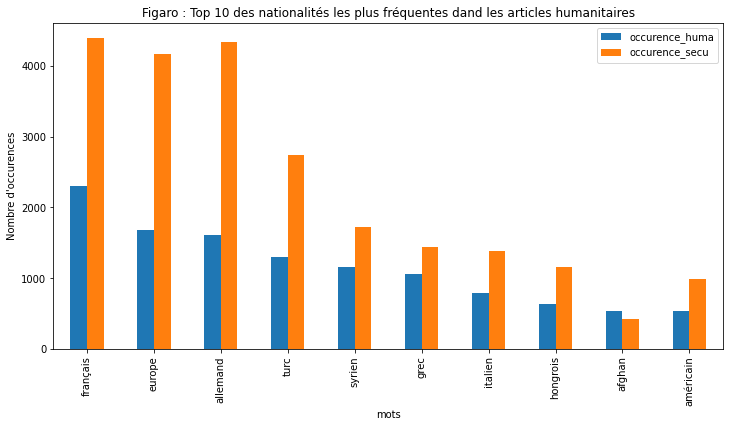

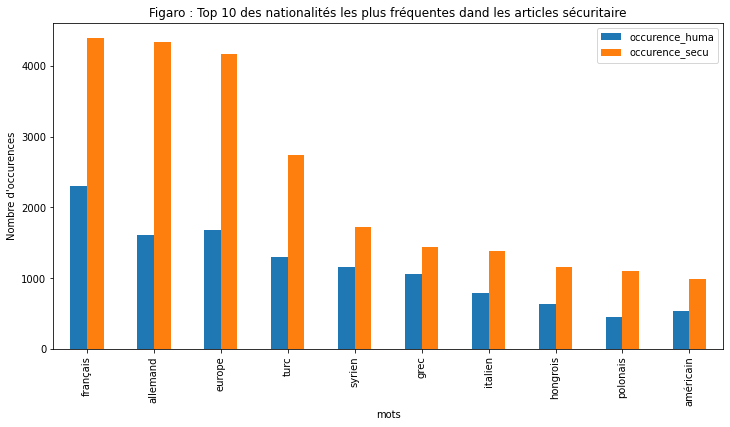

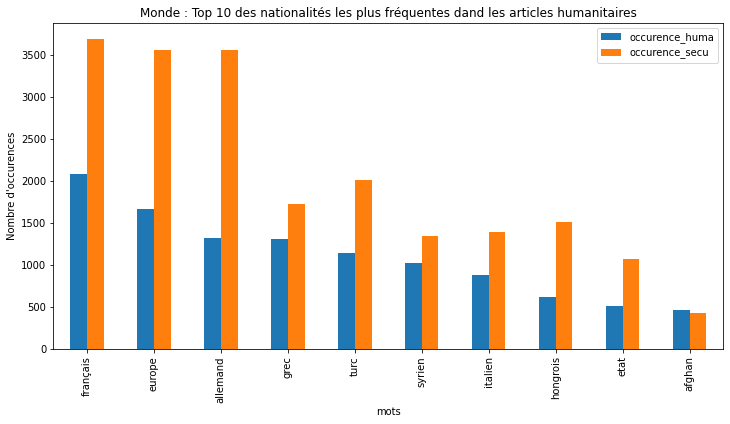

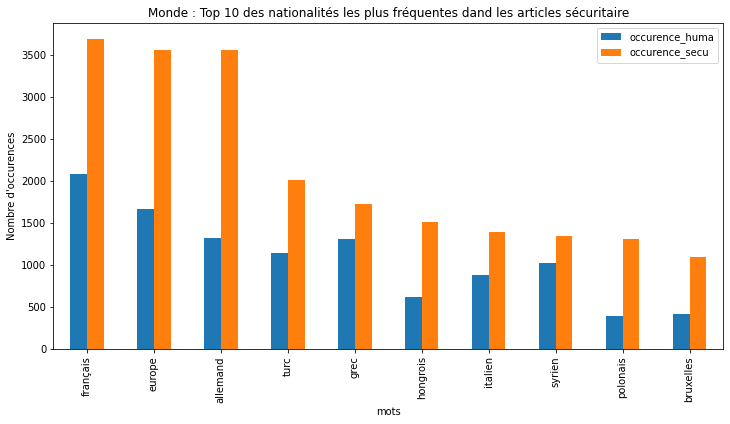

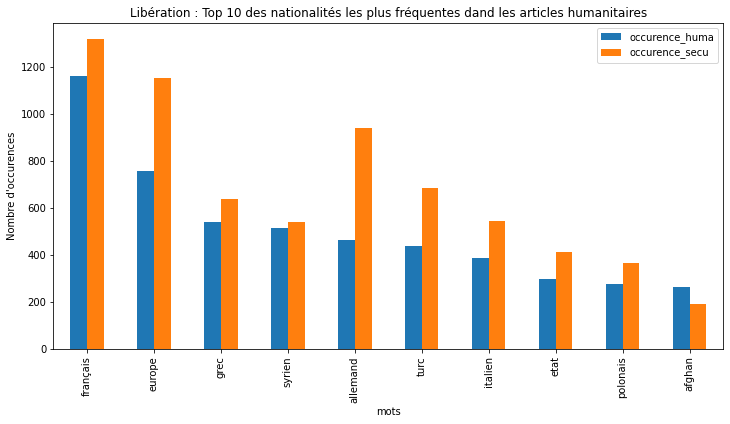

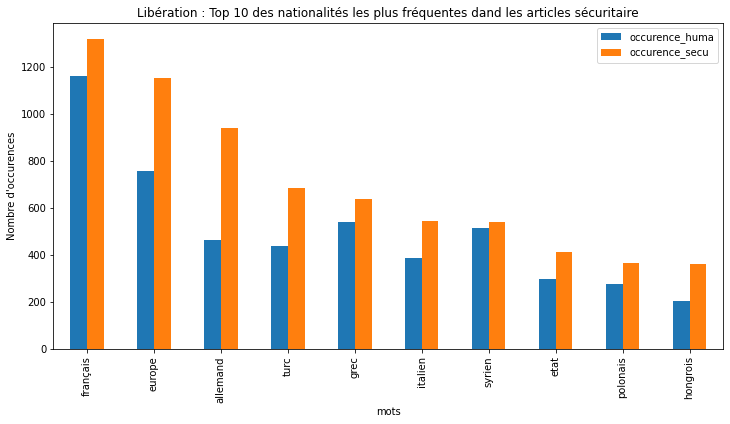

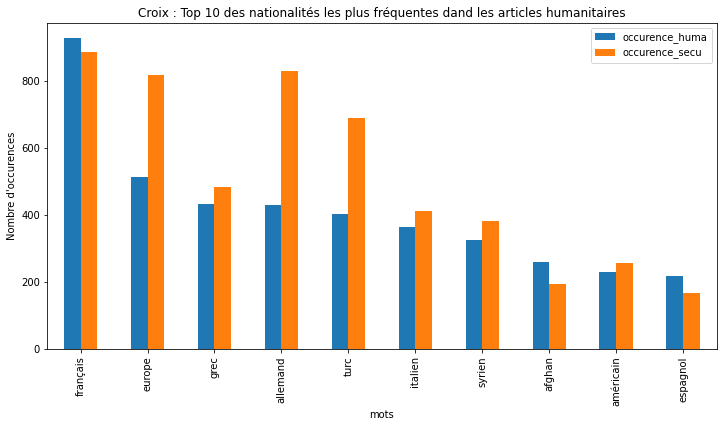

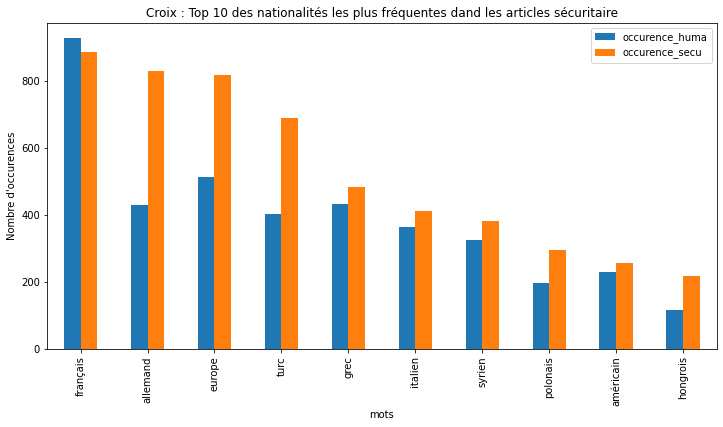

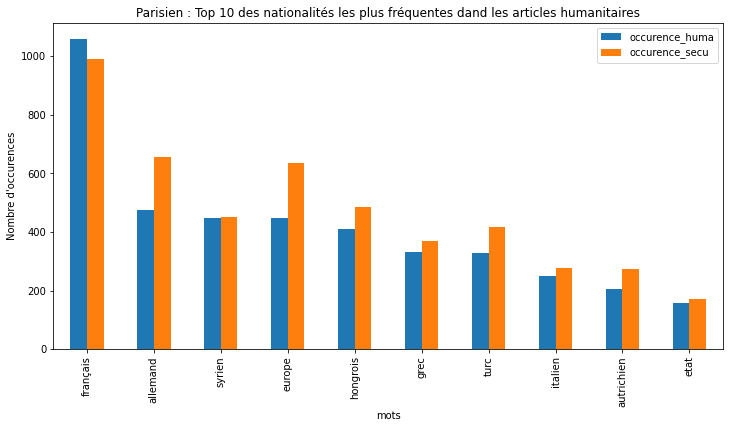

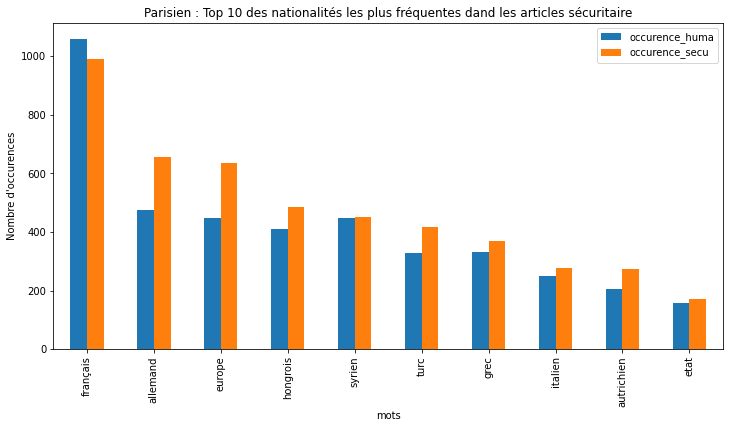

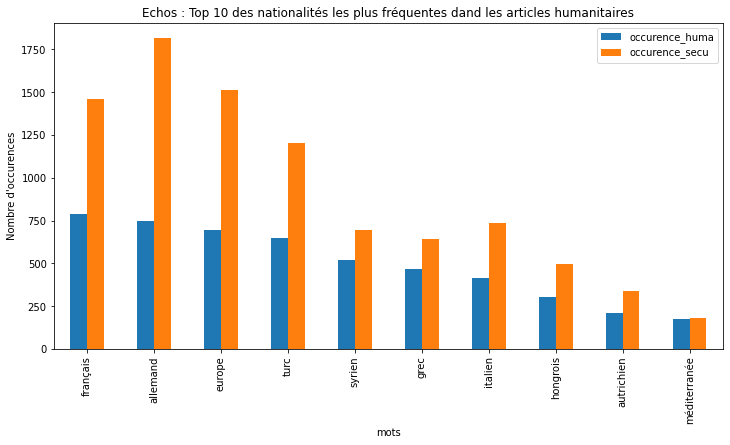

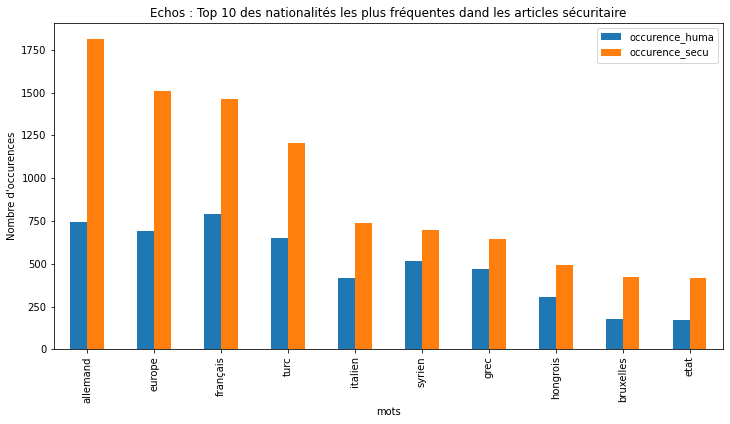

In [122]:
word_to_eliminate = ["l'","la","de","-","l'","l'","l’","la","le"]
stat = stat.loc[~(stat.mots.isin(word_to_eliminate))]
for journal in stat.journal.unique():
    data = stat.loc[stat.journal==journal,["mots","occurence_huma","occurence_secu"]].groupby("mots").sum()
    
    data.sort_values("occurence_huma",ascending=False).head(10).plot(kind='bar', figsize=(12, 6))
    plt.title(f'{journal} : Top 10 des nationalités les plus fréquentes dand les articles humanitaires')
    plt.ylabel('Nombre d\'occurences')
    
    data.sort_values("occurence_secu",ascending=False).head(10).plot(kind='bar', figsize=(12, 6))
    plt.title(f'{journal} : Top 10 des nationalités les plus fréquentes dand les articles sécuritaire')
    plt.ylabel('Nombre d\'occurences')
    
    plt.show()

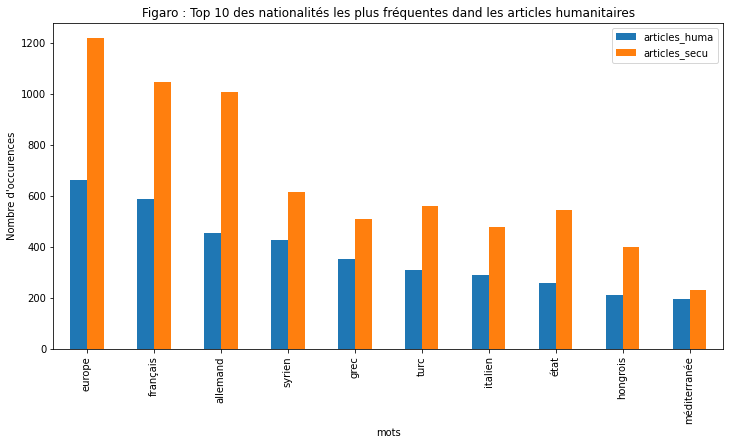

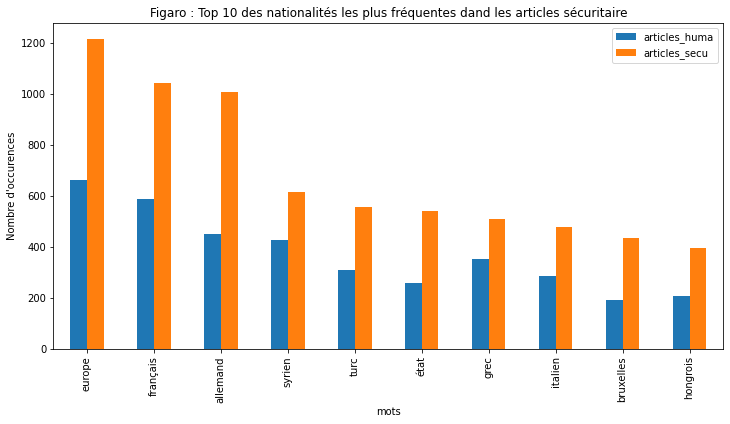

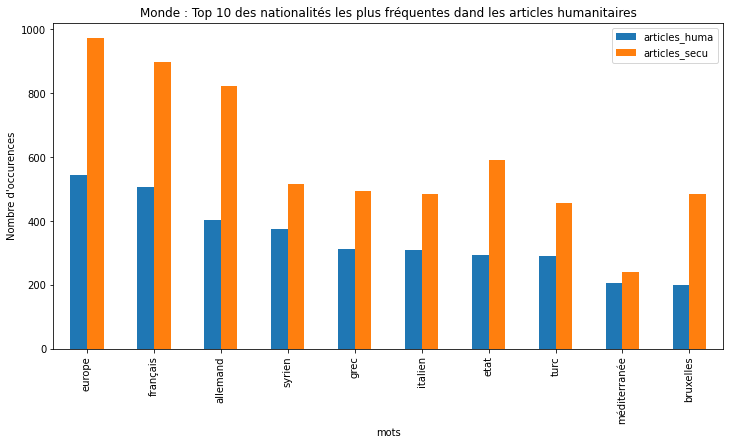

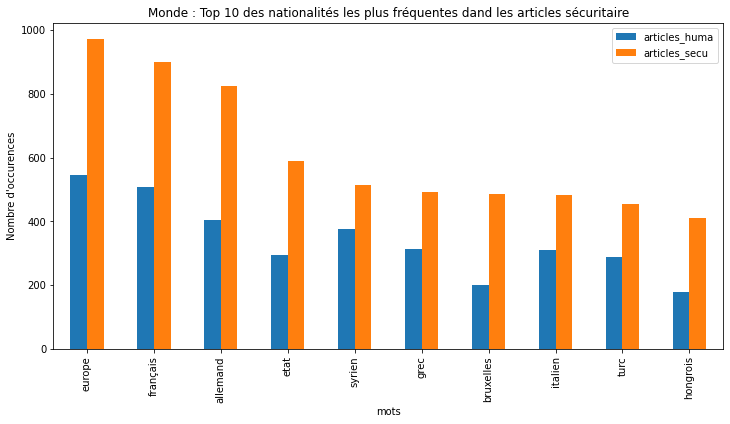

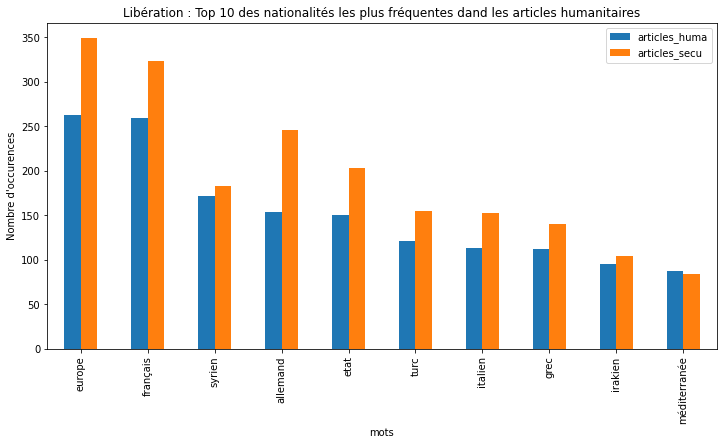

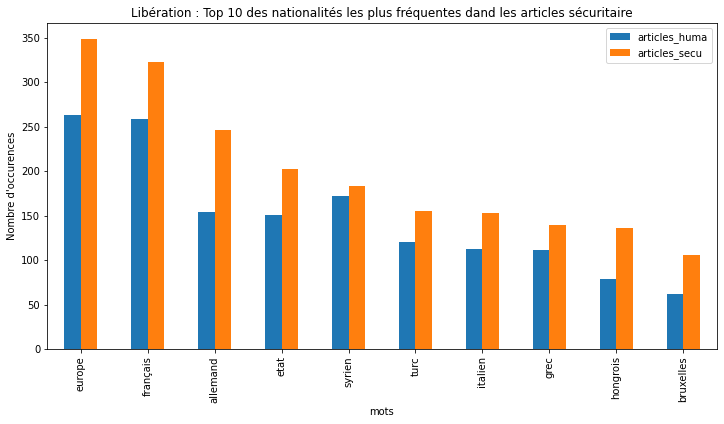

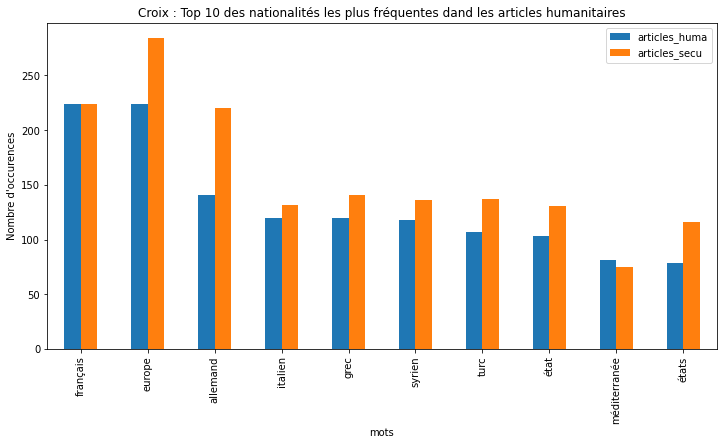

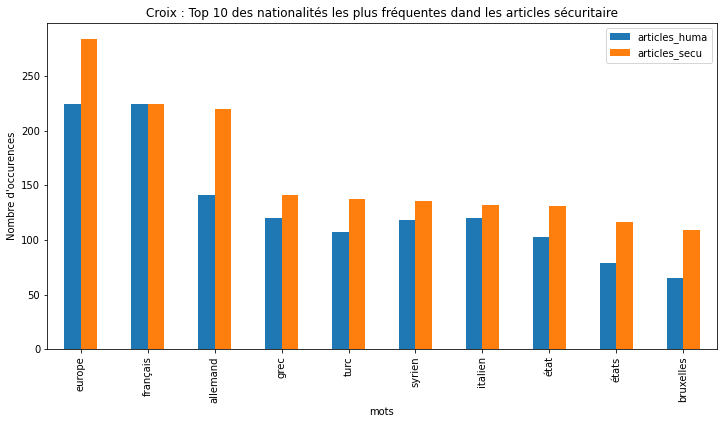

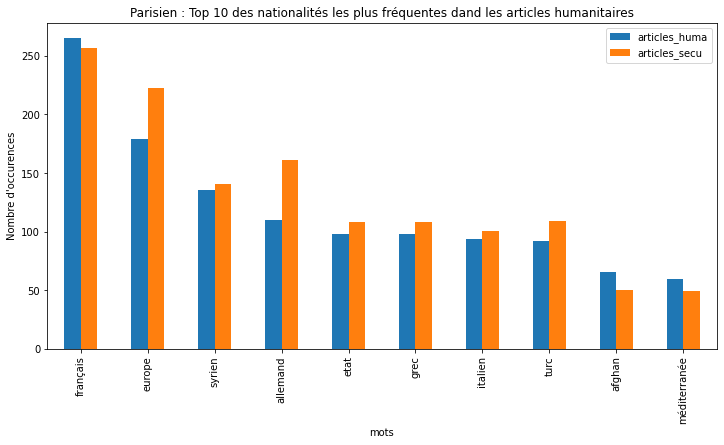

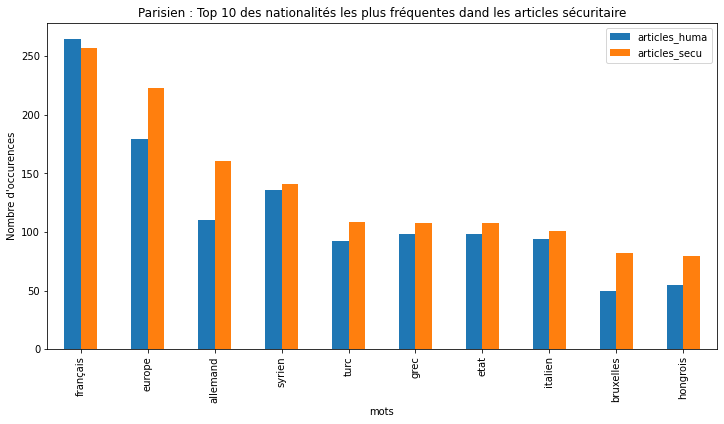

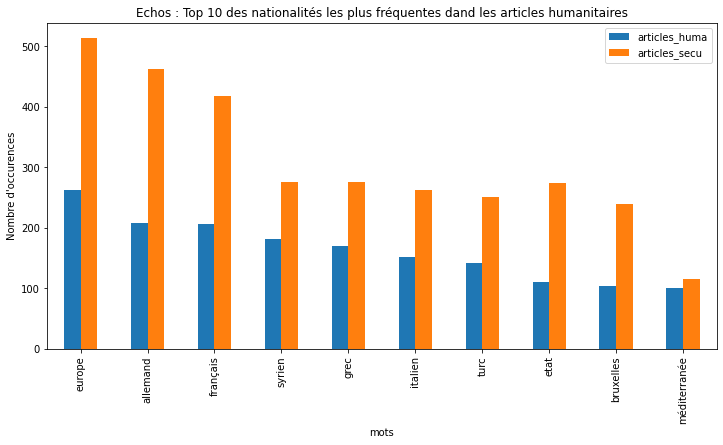

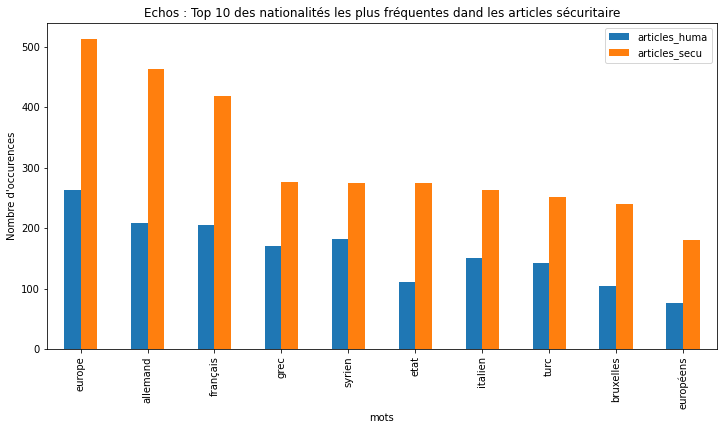

In [123]:
word_to_eliminate = ["l'","la","de","-","l'","l'","l’","la","le"]
stat = stat.loc[~(stat.mots.isin(word_to_eliminate))]
for journal in stat.journal.unique():
    data = stat.loc[stat.journal==journal,["mots","articles_huma","articles_secu"]].groupby("mots").sum()
    
    data.sort_values("articles_huma",ascending=False).head(10).plot(kind='bar', figsize=(12, 6))
    plt.title(f'{journal} : Top 10 des nationalités les plus fréquentes dand les articles humanitaires')
    plt.ylabel('Nombre d\'occurences')
    
    data.sort_values("articles_secu",ascending=False).head(10).plot(kind='bar', figsize=(12, 6))
    plt.title(f'{journal} : Top 10 des nationalités les plus fréquentes dand les articles sécuritaire')
    plt.ylabel('Nombre d\'occurences')
    
    plt.show()